# Info
RiJoshin, 2400013201;

人工智能基础第三次作业的实现，为方便图像显示与分模块修改

起于2025-04-03


## 第二课作业
用pytorch实现卷积神经网络，对cifar10数据集进行分类
要求:
1. 使用pytorch的nn.Module和Conv2d等相关的API实现卷积神经网络
2. 使用pytorch的DataLoader和Dataset等相关的API实现数据集的加载
3. 修改网络结构和参数，观察训练效果
4. 使用数据增强，提高模型的泛化能力



In [1]:
# import necessary packages
import os
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm import tqdm
# plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import datetime
import random
import string
import numpy as np

## 超参数

In [2]:
# 定义超参数
hyperparameters = {
    'batch_size': 128,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'early_stop_patience': 10
}
EARLY_STOP = False
DEBUG = False


## 数据裁剪

In [3]:

# 自定义高斯噪声变换
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        if np.random.rand() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # 归一化
])

# 数据增强的数据预处理方式
train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # 随机缩放裁剪
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 颜色扰动
    # transforms.RandomRotation(15),  # 小幅旋转
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # 随机擦除
    # AddGaussianNoise(mean=0., std=0.1, p=0.5),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 归一化
])


## 可视化训练过程

In [4]:

def visualize_training_progress(train_acc_list, train_loss_list, test_acc_list,
                                hyperparameters=None, model_architecture=None, 
                                description="", save_dir="training_logs", 
                                show_plot=True):
    """
    可视化训练过程的准确率和损失，并自动保存图表和相关参数。
    
    参数:
    - train_acc_list: 每个epoch的训练准确率列表
    - train_loss_list: 每个epoch的训练损失列表
    - test_acc_list: 每个epoch的测试准确率列表
    - hyperparameters: 超参数字典
    - model_architecture: 模型架构描述
    - description: 实验描述
    - save_dir: 保存图表和日志的目录
    - show_plot: 是否显示图表
    """
    
    # 创建保存目录
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # 生成唯一的文件名
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
    file_prefix = f"{timestamp}_{random_str}"
    
    # 创建图表
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), constrained_layout=True)
    
    # 绘制准确率
    epochs = np.arange(1, len(train_acc_list) + 1)
    ax1.plot(epochs, train_acc_list, 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, test_acc_list, 'r--', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='best')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 绘制损失
    ax2.plot(epochs, train_loss_list, 'g-', label='Training Loss', linewidth=2)
    ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # 添加描述信息
    fig.suptitle(f'Training Progress - {description}', fontsize=16, fontweight='bold')
    
    # 保存图表
    plot_filename = os.path.join(save_dir, f"{file_prefix}_training_progress.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    
    # 保存超参数和模型架构
    info_filename = os.path.join(save_dir, f"{file_prefix}_training_info.txt")
    with open(info_filename, 'w') as f:
        f.write(f"Training Progress Summary - {description}\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        
        if hyperparameters:
            f.write("Hyperparameters:\n")
            for key, value in hyperparameters.items():
                f.write(f"  {key}: {value}\n")
            f.write("\n")
        
        if model_architecture:
            f.write("Model Architecture:\n")
            f.write(f"{model_architecture}\n")
            f.write("\n")
        
        f.write("Training Accuracy: \n")
        f.write(f"{train_acc_list}\n\n")
        
        f.write("Training Loss: \n")
        f.write(f"{train_loss_list}\n\n")
        
        f.write("Validation Accuracy: \n")
        f.write(f"{test_acc_list}\n\n")

    
    if show_plot:
        plt.show()
    
    print(f"Training progress visualization saved to: {plot_filename}")
    print(f"Training information saved to: {info_filename}")
    # return plot_filename, info_filename

## load data

In [5]:

# 定义数据集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

In [6]:

# train
# Mean: tensor([-0.3301, -0.3376, -0.3116])
# Std: tensor([1.3983, 1.3937, 1.4152])

# test
# Mean: tensor([0.0139, 0.0147, 0.0194])
# Std: tensor([1.2192, 1.2181, 1.3015])

# # 初始化变量
# mean = 0.0
# std = 0.0

# # 计算均值
# for images, _ in test_loader:
#     batch_samples = images.size(0)  # 当前批次的样本数量
#     images = images.view(batch_samples, images.size(1), -1)  # 展平每个通道
#     mean += images.mean(2).sum(0)  # 按通道计算均值并累加

# mean = mean / len(test_loader.dataset)  # 计算全局均值

# # 计算标准差
# for images, _ in test_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     std += ((images - mean.unsqueeze(1)) ** 2).sum([0, 2])  # 按通道计算方差并累加

# std = torch.sqrt(std / (len(test_loader.dataset) * 32 * 32))  # 计算全局标准差

# print("Mean:", mean)
# print("Std:", std)

## Models


### Normal My Structure

In [7]:

# 定义模型
class Net(nn.Module):
    '''
    定义卷积神经网络,3个卷积层,2个全连接层
    '''
    def __init__(self, height, width):
        super(Net, self).__init__()

        self.image_height = height
        self.image_width = width

        # 先写死，后面改成根据输入参数构建网络维度的 TODO 最多5层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), # 3, H, W -> 32, H, W
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 32, H/2, W/2 -> 64, H/2, W/2
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # 64, H/4, W/4 -> 128, H/4, W/4
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # 128, H/8, W/8 -> 256, H/8, W/8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # 256, H/16, W/16 -> 512, H/16, W/16
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), 
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * (height // 32) * (width // 32), 4096), 
            nn.ReLU(inplace=True), 
            nn.Dropout(),
            nn.Linear(4096, 10),
            nn.Softmax(dim=1) # 10 -> 10
        )
    
    def forward(self, x: torch.Tensor):
        '''
        Args:
            x: tensor, shape [batch_size, 3, H, W]
        '''
        res = self.conv(x)
        if DEBUG:
            print("conv output shape: ", res.shape)
        res = res.view(res.size(0), -1)
        if DEBUG:
            print("conv flatten output shape: ", res.shape)
        res = self.fc(res)
        return res

### VGG16

In [8]:

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 1024),  # 输入维度调整为 512*1*1，因为 CIFAR-10 的图像大小是 32x32
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            # nn.Linear(1024, 4096),
            # nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### ResNet for fun

In [9]:

# ResNet
class BasicBlockForResNet(nn.Module):
    expansion = 1 # in_channel = expansion * out_channel
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockForResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) # !!!!!! TODO important
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) 

        self.shortcut = nn.Sequential() 
        if stride != 1 or in_channels != self.expansion * out_channels: # TODO
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,  self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True) # inplace=True, 直接在原来的内存上进行操作，节省内存开销

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out)) 
        out += self.shortcut(x) # 残差连接
        out = self.relu(out)
        return out

class ResNetTest(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetTest, self).__init__()


        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)

        # Kaiming初始化 # TODO 初始化，来自PPT    
        # 权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 构建多个残差块
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x))) 
        out = self.layer1(out) 
        out = self.layer2(out) 
        out = self.layer3(out) 
        out = self.layer4(out)  
        out = self.avg_pool(out) 
        out = out.view(out.size(0), -1) 
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Model的实例化

In [10]:

# 实例化模型
model = VGG16()
# model = ResNetTest(BasicBlockForResNet, [2, 2, 2, 2])


## Device

In [11]:

use_mlu = False # 爱了，喜欢这个判断
try:
    use_mlu = torch.mlu.is_available()
except:
    use_mlu = False

if use_mlu:
    device = torch.device('mlu:0')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    print(f'MLU is not available, use {device} instead.')

model = model.to(device)

# init model
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)
model.apply(weights_init)

MLU is not available, use cuda:0 instead.


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

## 选择lossFunction 以及 optimizer

In [12]:

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=5e-4) ## TODO


## Training!

### train function


In [13]:
def train_model(epoch):
    '''
    Args:
        epoch (int): 当前epoch次数
    Returns:
        并非list
        accuracie (Tensor): 本轮最后次统计的正确率
        losses     (Tensor): 同, loss
    '''
    # 训练模式
    model.train()
    accuracies = None
    losses = None
    # 使用 tqdm 包装数据加载器，显示训练进度
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{hyperparameters['num_epochs']}", unit="batch")
    
    for i, (images, labels) in enumerate(progress_bar):

        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (outputs.argmax(1) == labels).float().mean()

        # 打印训练信息
        if (i + 1) % 100 == 0:
            accuracies = accuracy.item()
            losses = loss.item()
            # 更新进度条信息
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Accuracy": f"{accuracy.item():.4f}"
            })

    return accuracies, losses
        

### test function

In [14]:
def test_model(epoch):
    '''
    没有传参数model, 把model当全局变量用了, 这样写的少些(其实是为了改回py文件时候好改, 只用复制粘贴就行, 不想起新名字折腾变量声明域了)
    Returns:
        test_acc (double): 测试正确率
    '''
    # 测试模式
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = correct / total

        print( f'    Epoch {epoch + 1}/{ hyperparameters["num_epochs"] } TestAccuracy: {test_acc:.2f}' )
        return test_acc
        # test_log = 'Test Accuracy of the model on the 10000 test images: {} %'.format(test_acc)
        # print(test_log)

### train的主循环

Epoch 1/100: 100%|██████████| 391/391 [00:15<00:00, 26.01batch/s, Loss=1.5641, Accuracy=0.3984]


    Epoch 1/100 TestAccuracy: 0.28


Epoch 2/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=1.3929, Accuracy=0.4375]


    Epoch 2/100 TestAccuracy: 0.50


Epoch 3/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=1.0975, Accuracy=0.5781]


    Epoch 3/100 TestAccuracy: 0.53


Epoch 4/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.9838, Accuracy=0.6797]


    Epoch 4/100 TestAccuracy: 0.64


Epoch 5/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.8902, Accuracy=0.7031]


    Epoch 5/100 TestAccuracy: 0.68


Epoch 6/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.8078, Accuracy=0.7031]


    Epoch 6/100 TestAccuracy: 0.66


Epoch 7/100: 100%|██████████| 391/391 [00:14<00:00, 26.40batch/s, Loss=0.8593, Accuracy=0.7188]


    Epoch 7/100 TestAccuracy: 0.74


Epoch 8/100: 100%|██████████| 391/391 [00:14<00:00, 26.40batch/s, Loss=0.7543, Accuracy=0.7422]


    Epoch 8/100 TestAccuracy: 0.76


Epoch 9/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.6497, Accuracy=0.8203]


    Epoch 9/100 TestAccuracy: 0.79


Epoch 10/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.6704, Accuracy=0.7812]


    Epoch 10/100 TestAccuracy: 0.80


Epoch 11/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.3930, Accuracy=0.8828]


    Epoch 11/100 TestAccuracy: 0.82


Epoch 12/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.4789, Accuracy=0.8359]


    Epoch 12/100 TestAccuracy: 0.84


Epoch 13/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.5037, Accuracy=0.8359]


    Epoch 13/100 TestAccuracy: 0.82


Epoch 14/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.4876, Accuracy=0.8516]


    Epoch 14/100 TestAccuracy: 0.82


Epoch 15/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.2147, Accuracy=0.9531]


    Epoch 15/100 TestAccuracy: 0.83


Epoch 16/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3507, Accuracy=0.8906]


    Epoch 16/100 TestAccuracy: 0.84


Epoch 17/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3305, Accuracy=0.8906]


    Epoch 17/100 TestAccuracy: 0.83


Epoch 18/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3533, Accuracy=0.8750]


    Epoch 18/100 TestAccuracy: 0.85


Epoch 19/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.4863, Accuracy=0.8359]


    Epoch 19/100 TestAccuracy: 0.84


Epoch 20/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2394, Accuracy=0.9141]


    Epoch 20/100 TestAccuracy: 0.86


Epoch 21/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2617, Accuracy=0.9297]


    Epoch 21/100 TestAccuracy: 0.86


Epoch 22/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3923, Accuracy=0.8828]


    Epoch 22/100 TestAccuracy: 0.86


Epoch 23/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3042, Accuracy=0.9062]


    Epoch 23/100 TestAccuracy: 0.85


Epoch 24/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2840, Accuracy=0.8984]


    Epoch 24/100 TestAccuracy: 0.84


Epoch 25/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.3424, Accuracy=0.8906]


    Epoch 25/100 TestAccuracy: 0.85


Epoch 26/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.4577, Accuracy=0.8359]


    Epoch 26/100 TestAccuracy: 0.87


Epoch 27/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3224, Accuracy=0.8828]


    Epoch 27/100 TestAccuracy: 0.83


Epoch 28/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3104, Accuracy=0.9141]


    Epoch 28/100 TestAccuracy: 0.85


Epoch 29/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2370, Accuracy=0.9297]


    Epoch 29/100 TestAccuracy: 0.85


Epoch 30/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2713, Accuracy=0.9219]


    Epoch 30/100 TestAccuracy: 0.86


Epoch 31/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2559, Accuracy=0.8984]


    Epoch 31/100 TestAccuracy: 0.87


Epoch 32/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1898, Accuracy=0.9141]


    Epoch 32/100 TestAccuracy: 0.86


Epoch 33/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2238, Accuracy=0.9375]


    Epoch 33/100 TestAccuracy: 0.86


Epoch 34/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2902, Accuracy=0.8906]


    Epoch 34/100 TestAccuracy: 0.87


Epoch 35/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.2201, Accuracy=0.9062]


    Epoch 35/100 TestAccuracy: 0.85


Epoch 36/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2422, Accuracy=0.9141]


    Epoch 36/100 TestAccuracy: 0.86


Epoch 37/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.3392, Accuracy=0.8984]


    Epoch 37/100 TestAccuracy: 0.86


Epoch 38/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.3551, Accuracy=0.8828]


    Epoch 38/100 TestAccuracy: 0.87


Epoch 39/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2045, Accuracy=0.9297]


    Epoch 39/100 TestAccuracy: 0.86


Epoch 40/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3289, Accuracy=0.8984]


    Epoch 40/100 TestAccuracy: 0.87


Epoch 41/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1706, Accuracy=0.9609]


    Epoch 41/100 TestAccuracy: 0.86


Epoch 42/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2073, Accuracy=0.9219]


    Epoch 42/100 TestAccuracy: 0.87


Epoch 43/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1879, Accuracy=0.9297]


    Epoch 43/100 TestAccuracy: 0.86


Epoch 44/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.3647, Accuracy=0.8594]


    Epoch 44/100 TestAccuracy: 0.88


Epoch 45/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.2265, Accuracy=0.9219]


    Epoch 45/100 TestAccuracy: 0.88


Epoch 46/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1883, Accuracy=0.9453]


    Epoch 46/100 TestAccuracy: 0.86


Epoch 47/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.3135, Accuracy=0.8984]


    Epoch 47/100 TestAccuracy: 0.87


Epoch 48/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1643, Accuracy=0.9453]


    Epoch 48/100 TestAccuracy: 0.86


Epoch 49/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2541, Accuracy=0.9297]


    Epoch 49/100 TestAccuracy: 0.87


Epoch 50/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1929, Accuracy=0.9453]


    Epoch 50/100 TestAccuracy: 0.86


Epoch 51/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1969, Accuracy=0.9453]


    Epoch 51/100 TestAccuracy: 0.89


Epoch 52/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3103, Accuracy=0.8906]


    Epoch 52/100 TestAccuracy: 0.87


Epoch 53/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2737, Accuracy=0.8828]


    Epoch 53/100 TestAccuracy: 0.88


Epoch 54/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2635, Accuracy=0.9141]


    Epoch 54/100 TestAccuracy: 0.88


Epoch 55/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2601, Accuracy=0.8828]


    Epoch 55/100 TestAccuracy: 0.86


Epoch 56/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.1869, Accuracy=0.9453]


    Epoch 56/100 TestAccuracy: 0.87


Epoch 57/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.3124, Accuracy=0.8984]


    Epoch 57/100 TestAccuracy: 0.86


Epoch 58/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.3344, Accuracy=0.8828]


    Epoch 58/100 TestAccuracy: 0.87


Epoch 59/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2480, Accuracy=0.9297]


    Epoch 59/100 TestAccuracy: 0.87


Epoch 60/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.3170, Accuracy=0.8984]


    Epoch 60/100 TestAccuracy: 0.88


Epoch 61/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.2940, Accuracy=0.8828]


    Epoch 61/100 TestAccuracy: 0.87


Epoch 62/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.1720, Accuracy=0.9453]


    Epoch 62/100 TestAccuracy: 0.87


Epoch 63/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2236, Accuracy=0.9219]


    Epoch 63/100 TestAccuracy: 0.88


Epoch 64/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.1448, Accuracy=0.9688]


    Epoch 64/100 TestAccuracy: 0.88


Epoch 65/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2032, Accuracy=0.9375]


    Epoch 65/100 TestAccuracy: 0.88


Epoch 66/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2461, Accuracy=0.9219]


    Epoch 66/100 TestAccuracy: 0.88


Epoch 67/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2087, Accuracy=0.9375]


    Epoch 67/100 TestAccuracy: 0.88


Epoch 68/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1504, Accuracy=0.9609]


    Epoch 68/100 TestAccuracy: 0.86


Epoch 69/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1649, Accuracy=0.9453]


    Epoch 69/100 TestAccuracy: 0.88


Epoch 70/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1408, Accuracy=0.9453]


    Epoch 70/100 TestAccuracy: 0.88


Epoch 71/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.2385, Accuracy=0.9375]


    Epoch 71/100 TestAccuracy: 0.87


Epoch 72/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1784, Accuracy=0.9375]


    Epoch 72/100 TestAccuracy: 0.86


Epoch 73/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1939, Accuracy=0.9219]


    Epoch 73/100 TestAccuracy: 0.87


Epoch 74/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2581, Accuracy=0.9141]


    Epoch 74/100 TestAccuracy: 0.86


Epoch 75/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1857, Accuracy=0.9297]


    Epoch 75/100 TestAccuracy: 0.87


Epoch 76/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2623, Accuracy=0.9062]


    Epoch 76/100 TestAccuracy: 0.87


Epoch 77/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2372, Accuracy=0.9141]


    Epoch 77/100 TestAccuracy: 0.88


Epoch 78/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1543, Accuracy=0.9531]


    Epoch 78/100 TestAccuracy: 0.89


Epoch 79/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2746, Accuracy=0.9375]


    Epoch 79/100 TestAccuracy: 0.87


Epoch 80/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.3003, Accuracy=0.9062]


    Epoch 80/100 TestAccuracy: 0.88


Epoch 81/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2771, Accuracy=0.9141]


    Epoch 81/100 TestAccuracy: 0.87


Epoch 82/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2307, Accuracy=0.9297]


    Epoch 82/100 TestAccuracy: 0.86


Epoch 83/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2388, Accuracy=0.9062]


    Epoch 83/100 TestAccuracy: 0.87


Epoch 84/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1641, Accuracy=0.9297]


    Epoch 84/100 TestAccuracy: 0.89


Epoch 85/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1488, Accuracy=0.9375]


    Epoch 85/100 TestAccuracy: 0.87


Epoch 86/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.1614, Accuracy=0.9609]


    Epoch 86/100 TestAccuracy: 0.87


Epoch 87/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1880, Accuracy=0.9297]


    Epoch 87/100 TestAccuracy: 0.88


Epoch 88/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.0537, Accuracy=0.9922]


    Epoch 88/100 TestAccuracy: 0.87


Epoch 89/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1585, Accuracy=0.9375]


    Epoch 89/100 TestAccuracy: 0.88


Epoch 90/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.4183, Accuracy=0.8750]


    Epoch 90/100 TestAccuracy: 0.88


Epoch 91/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.2105, Accuracy=0.9219]


    Epoch 91/100 TestAccuracy: 0.87


Epoch 92/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.0995, Accuracy=0.9609]


    Epoch 92/100 TestAccuracy: 0.87


Epoch 93/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1149, Accuracy=0.9688]


    Epoch 93/100 TestAccuracy: 0.87


Epoch 94/100: 100%|██████████| 391/391 [00:14<00:00, 26.43batch/s, Loss=0.2018, Accuracy=0.9453]


    Epoch 94/100 TestAccuracy: 0.87


Epoch 95/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.0610, Accuracy=0.9844]


    Epoch 95/100 TestAccuracy: 0.87


Epoch 96/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.0928, Accuracy=0.9531]


    Epoch 96/100 TestAccuracy: 0.88


Epoch 97/100: 100%|██████████| 391/391 [00:14<00:00, 26.44batch/s, Loss=0.1612, Accuracy=0.9531]


    Epoch 97/100 TestAccuracy: 0.87


Epoch 98/100: 100%|██████████| 391/391 [00:14<00:00, 26.45batch/s, Loss=0.2510, Accuracy=0.9141]


    Epoch 98/100 TestAccuracy: 0.89


Epoch 99/100: 100%|██████████| 391/391 [00:14<00:00, 26.41batch/s, Loss=0.1752, Accuracy=0.9297]


    Epoch 99/100 TestAccuracy: 0.88


Epoch 100/100: 100%|██████████| 391/391 [00:14<00:00, 26.42batch/s, Loss=0.1201, Accuracy=0.9531]


    Epoch 100/100 TestAccuracy: 0.87


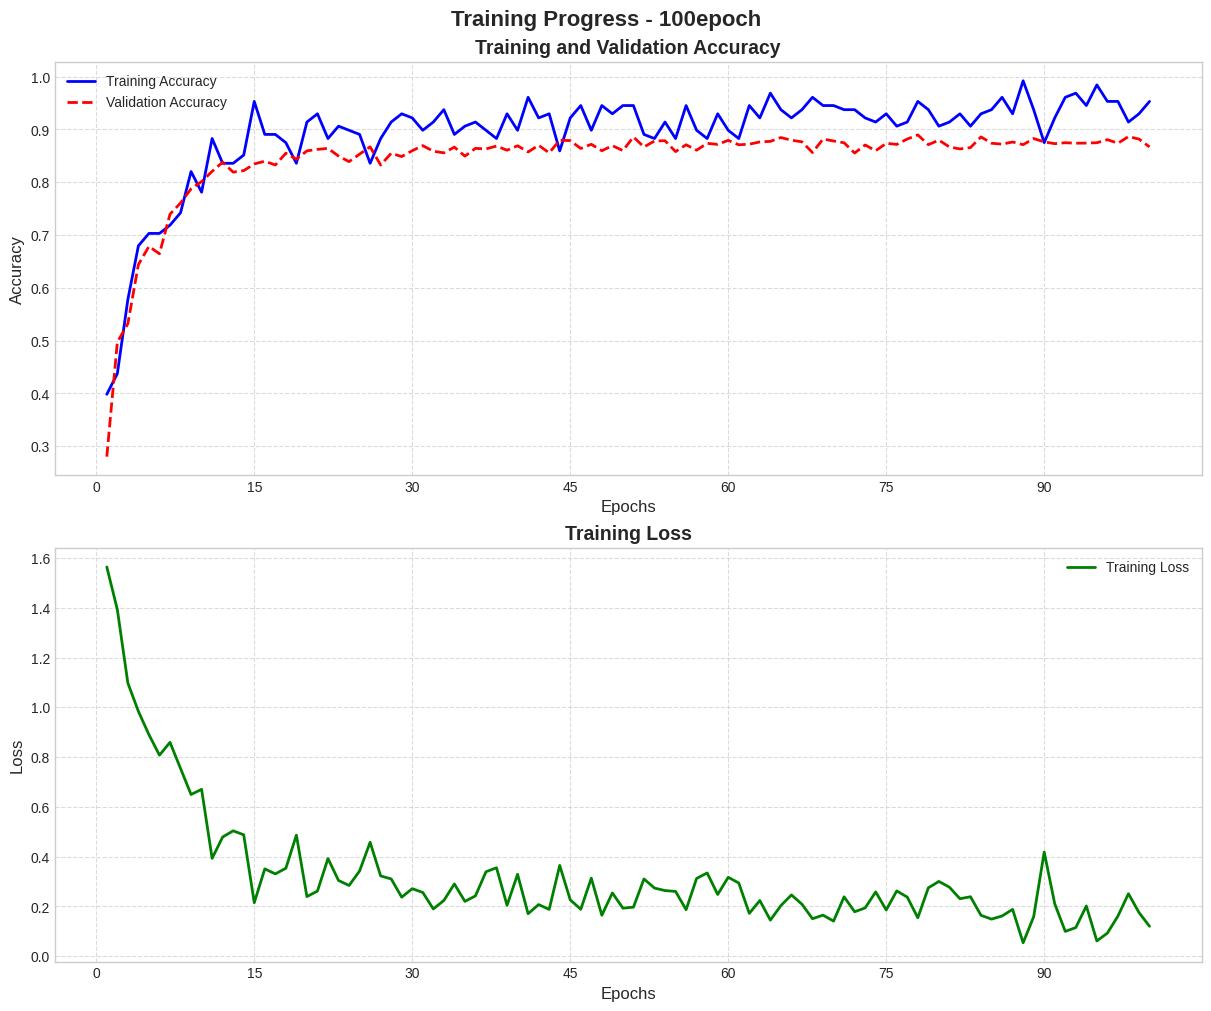

Training progress visualization saved to: training_logs/20250406_195947_QYUZWU_training_progress.png
Training information saved to: training_logs/20250406_195947_QYUZWU_training_info.txt


In [15]:

best_accuracy = 0.0
counter = 0


epoch_train_acc_list = []
epoch_train_loss_list = []
epoch_test_acc_list = []
# 训练模型
for epoch in range(hyperparameters['num_epochs']):
    train_acc, train_loss = train_model(epoch)
    test_acc = test_model(epoch)

    # early stopping
    if EARLY_STOP:
        if (test_acc > best_accuracy):
            best_accuracy = test_acc
            counter = 0
        else:
            counter += 1
            print(f"Early stopping counter: {counter}")
            if counter > hyperparameters['early_stop_patience']:
                print("Early stopping")
                break
    
    epoch_train_acc_list.append(train_acc)
    epoch_train_loss_list.append(train_loss)
    epoch_test_acc_list.append(test_acc)


message = input("Please type some information here as mdescription:\n    ")
visualize_training_progress(
        train_acc_list=epoch_train_acc_list,
        train_loss_list=epoch_train_loss_list,
        test_acc_list=epoch_test_acc_list,
        hyperparameters=hyperparameters,
        model_architecture=str(model),
        description=message,
        save_dir="training_logs"
)
    